<a href="https://colab.research.google.com/github/RealB1ackY/ISnT_Lab13-16/blob/main/Lab_13_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 6.1 MB/s 
     |████████████████████████████████| 965 kB 68.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import time

from sklearn import preprocessing

# Devices on which the CPU and GPU are trained

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading data

In [ ]:
train_data_url = 'http://azuremlsamples.azureml.net/templatedata/PM_train.txt'
test_data_url = 'http://azuremlsamples.azureml.net/templatedata/PM_test.txt'
truth_data_url = 'http://azuremlsamples.azureml.net/templatedata/PM_truth.txt'

if not 'data' in os.listdir(): 
    os.mkdir('data')

cache_dir = os.path.join(os.path.realpath(os.curdir), 'data')
print(cache_dir)

/content/data


In [ ]:
train_data_path = tf.keras.utils.get_file('train_data.txt', train_data_url, cache_dir=cache_dir)
test_data_path = tf.keras.utils.get_file('test_data.txt', test_data_url, cache_dir=cache_dir)
truth_data_path = tf.keras.utils.get_file('truth_data.txt', truth_data_url, cache_dir=cache_dir)

# Converting training data

In [ ]:
# Columns
column_names = ['id', 'cycle', 'set_1', 'set_2', 'set_3', 's1', 's2', 's3',
                's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
train_df = pd.read_csv(train_data_path, sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = column_names

In [ ]:
test_df = pd.read_csv(test_data_path, sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns =  column_names

In [ ]:
truth_df = pd.read_csv(truth_data_path, sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [ ]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head() 

,id,cycle,set_1,set_2,set_3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,set_1,set_2,set_3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
w1 = 30
w2 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w2, 'label2'] = 2
train_df.head()

,id,cycle,set_1,set_2,set_3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [ ]:
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,set_1,set_2,set_3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [ ]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,set_1,set_2,set_3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [ ]:
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [ ]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,set_1,set_2,set_3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [ ]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w2, 'label2'] = 2
test_df.head()

,id,cycle,set_1,set_2,set_3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


# Data visualization

In [ ]:
# 50 cycles
sequence_length = 50

In [ ]:
engine_id = test_df[test_df['id'] == 5]
engine_id_50cycleWindow = engine_id[engine_id['RUL'] <= engine_id['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id_50cycleWindow1 = engine_id_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id_50cycleWindow2 = engine_id_50cycleWindow[cols2]

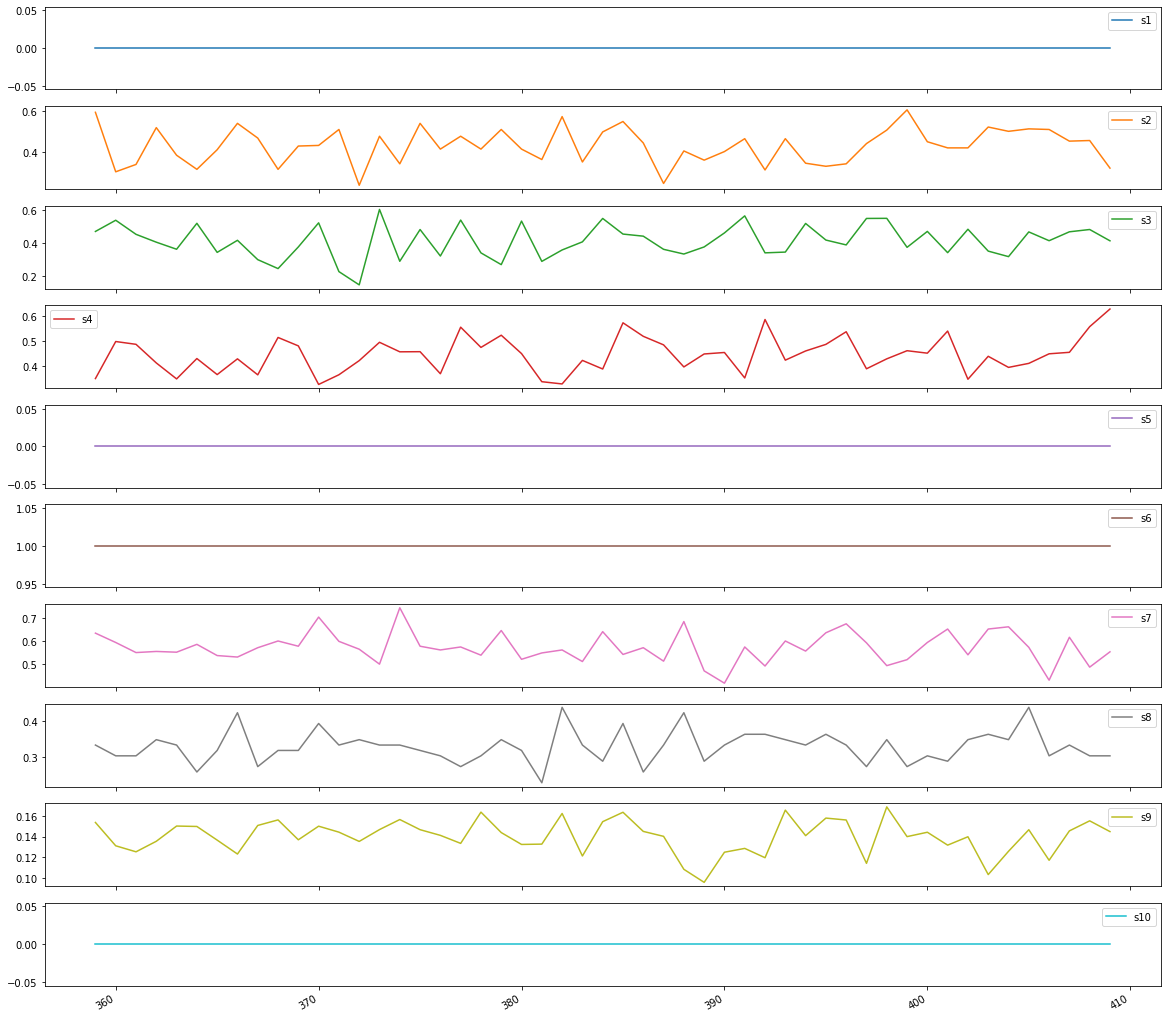

In [ ]:
# Sensors 1-10
ax1 = engine_id_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

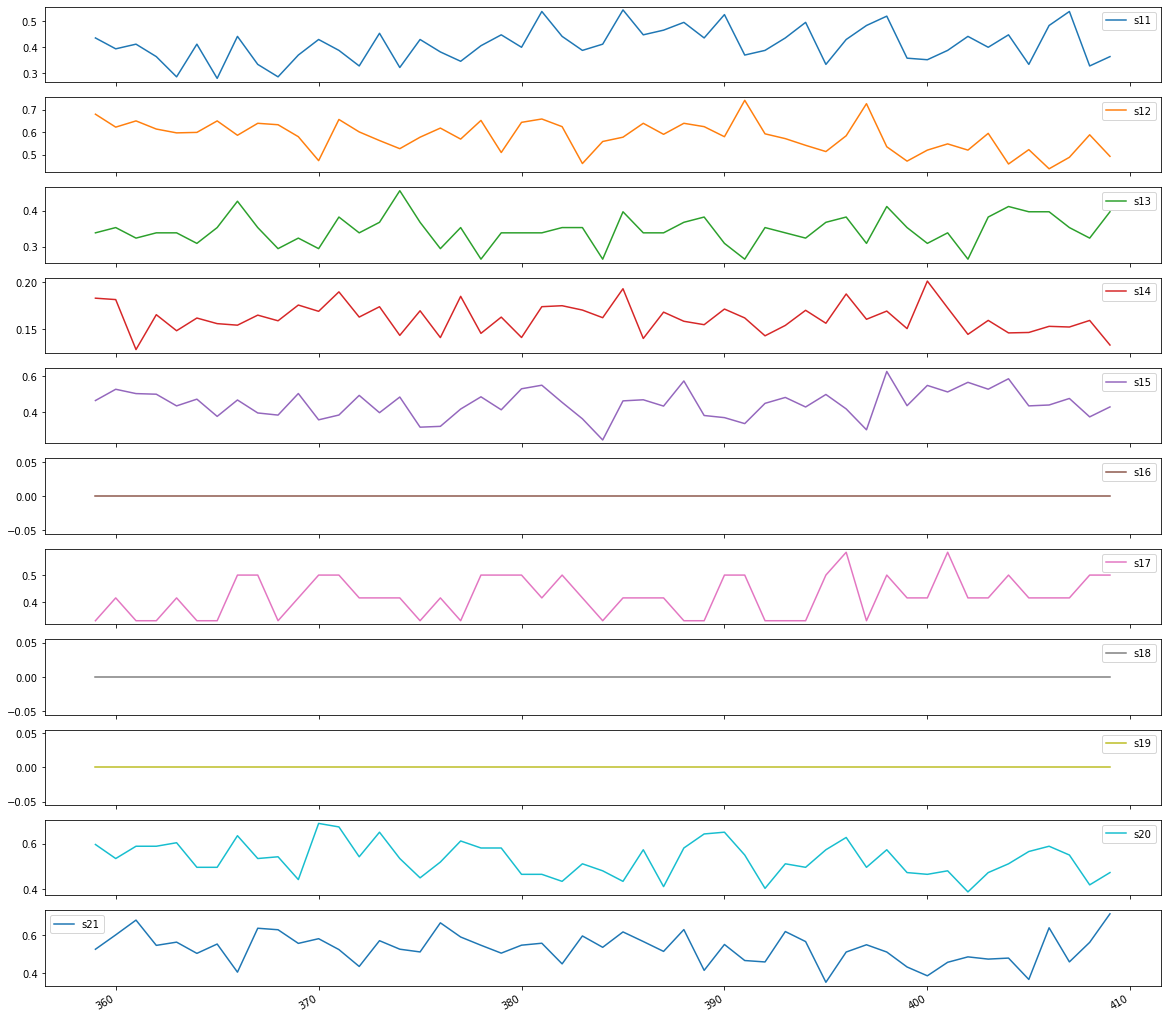

In [ ]:
# Sensors 11-21
ax2 = engine_id_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

# Creating datasets

In [ ]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [ ]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [ ]:
def create_train_dataset():
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['set_1', 'set_2', 'set_3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)

    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) for id in train_df['id'].unique())
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
                       for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return seq_array, label_array


In [ ]:
def create_test_dataset():
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['set_1', 'set_2', 'set_3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
    seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                           for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

    y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
    label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
    return seq_array_test_last, label_array_test_last

In [ ]:
# Creating two datasets
train_data, train_labels = create_train_dataset() # train data
test_data, test_labels = create_test_dataset() # test data

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(200)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(200)

train_dataset, test_dataset

(<BatchDataset shapes: ((None, 50, 25), (None, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 50, 25), (None, 1)), types: (tf.float32, tf.float32)>)

# Train models

In [ ]:
# Training
nb_features = train_dataset.element_spec[0].shape[-1] 
nb_out = train_dataset.element_spec[1].shape[-1] 

evaluate_metrics = [ 
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [ ]:
# rnn, lstm, gru
def build_model(model_type='rnn', metrics=[tf.keras.metrics.BinaryAccuracy()]):
    if model_type == 'rnn':
        rnn_first = tf.keras.layers.SimpleRNN(100, return_sequences=True)
        rnn_second = tf.keras.layers.SimpleRNN(50, return_sequences=False)
    elif model_type == 'lstm':
        rnn_first = tf.keras.layers.LSTM(100, return_sequences=True)
        rnn_second = tf.keras.layers.LSTM(50, return_sequences=False)
    elif model_type == 'gru':
        rnn_first = tf.keras.layers.GRU(100, return_sequences=True)
        rnn_second = tf.keras.layers.GRU(50, return_sequences=False)
    else:
        raise ValueError("model_type should be one of 'rnn', 'lstm' or 'gru'")

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((sequence_length, nb_features)),
        rnn_first,
        tf.keras.layers.Dropout(0.2),
        rnn_second,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(nb_out, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    return model

In [ ]:
# train_model
def train_model(model, epochs=10, verbose=1):
    start_time = time.time()
    history = model.fit(
        train_dataset,
        epochs=epochs, 
        validation_data=test_dataset, 
        verbose=verbose,
    )

    train_time = time.time() - start_time
    return history, train_time

In [ ]:
def plot_history(history: tf.keras.callbacks.History):
    plt.figure(figsize=(10, 5))

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')

    plt.plot(history.history['binary_accuracy'], label='train accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='validation accuracy')

    plt.legend(loc='upper right', bbox_to_anchor=(1.27, 1),
               fancybox=True, shadow=True)
    plt.xlabel('Epochs')
    plt.xticks(list(range(len(history.history['loss']))))
    plt.ylabel('Loss and accuracy')
    plt.show()

# LSTM model

In [ ]:
lstm_model = build_model('lstm')

lstm_model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history, lstm_train_time = train_model(lstm_model) 

Epoch 1/10
79/79 [==============================] - 14s 47ms/step - loss: 0.3244 - binary_accuracy: 0.8647 - val_loss: 0.2704 - val_binary_accuracy: 0.8925
Epoch 2/10
79/79 [==============================] - 3s 36ms/step - loss: 0.1988 - binary_accuracy: 0.9188 - val_loss: 0.2151 - val_binary_accuracy: 0.9140
Epoch 3/10
79/79 [==============================] - 3s 36ms/step - loss: 0.1683 - binary_accuracy: 0.9356 - val_loss: 0.2071 - val_binary_accuracy: 0.9032
Epoch 4/10
79/79 [==============================] - 3s 36ms/step - loss: 0.1578 - binary_accuracy: 0.9376 - val_loss: 0.1688 - val_binary_accuracy: 0.9355
Epoch 5/10
79/79 [==============================] - 3s 36ms/step - loss: 0.1291 - binary_accuracy: 0.9472 - val_loss: 0.1265 - val_binary_accuracy: 0.9462
Epoch 6/10
79/79 [==============================] - 3s 35ms/step - loss: 0.1096 - binary_accuracy: 0.9549 - val_loss: 0.0906 - val_binary_accuracy: 0.9785
Epoch 7/10
79/79 [==============================] - 3s 35ms/step - lo

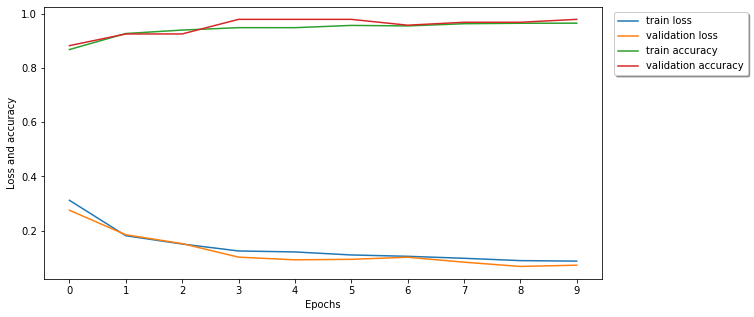

In [ ]:
plot_history(lstm_history) # График показывающий как менялась функция потери и точности, снизу - функция потерь, сверху точность, на тестовых и тренировочных данных

In [ ]:
# Calculating metrics
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=evaluate_metrics
)
lstm_scores = lstm_model.evaluate(test_dataset, return_dict=True)

1/1 [==============================] - 2s 2s/step - loss: 0.0751 - binary_accuracy: 0.9677 - precision: 0.9231 - recall: 0.9600


# GRU model 

In [ ]:
gru_model = build_model('gru')

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 100)           38100     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,951
Trainable params: 60,951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_history, gru_train_time = train_model(gru_model)

Epoch 1/10
79/79 [==============================] - 13s 70ms/step - loss: 0.3014 - binary_accuracy: 0.8722 - val_loss: 0.2566 - val_binary_accuracy: 0.8817
Epoch 2/10
79/79 [==============================] - 3s 33ms/step - loss: 0.1683 - binary_accuracy: 0.9307 - val_loss: 0.2457 - val_binary_accuracy: 0.8925
Epoch 3/10
79/79 [==============================] - 3s 33ms/step - loss: 0.1537 - binary_accuracy: 0.9360 - val_loss: 0.2275 - val_binary_accuracy: 0.9032
Epoch 4/10
79/79 [==============================] - 3s 34ms/step - loss: 0.1424 - binary_accuracy: 0.9412 - val_loss: 0.1884 - val_binary_accuracy: 0.9355
Epoch 5/10
79/79 [==============================] - 3s 33ms/step - loss: 0.1215 - binary_accuracy: 0.9474 - val_loss: 0.1041 - val_binary_accuracy: 0.9462
Epoch 6/10
79/79 [==============================] - 3s 34ms/step - loss: 0.1063 - binary_accuracy: 0.9568 - val_loss: 0.0583 - val_binary_accuracy: 0.9785
Epoch 7/10
79/79 [==============================] - 3s 34ms/step - lo

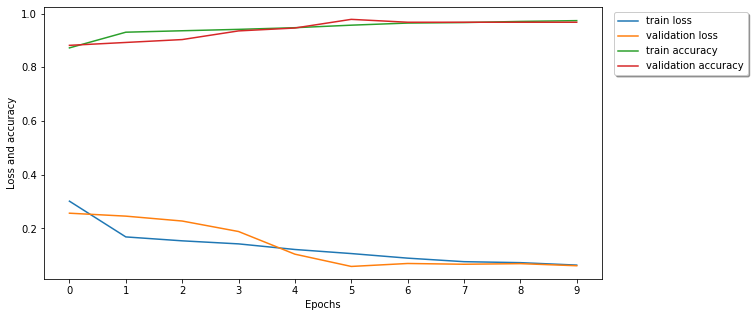

In [ ]:
plot_history(gru_history)

In [ ]:
gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=evaluate_metrics
)
gru_scores = gru_model.evaluate(test_dataset, return_dict=True)

1/1 [==============================] - 1s 1s/step - loss: 0.0609 - binary_accuracy: 0.9677 - precision: 0.9231 - recall: 0.9600


# SimpleRNN model

In [ ]:
rnn_model = build_model('rnn')

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 100)           12600     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_history, rnn_train_time = train_model(rnn_model)

Epoch 1/10
79/79 [==============================] - 14s 150ms/step - loss: 0.2521 - binary_accuracy: 0.8996 - val_loss: 0.2264 - val_binary_accuracy: 0.8925
Epoch 2/10
79/79 [==============================] - 12s 155ms/step - loss: 0.2275 - binary_accuracy: 0.9111 - val_loss: 0.2412 - val_binary_accuracy: 0.9140
Epoch 3/10
79/79 [==============================] - 12s 146ms/step - loss: 0.1744 - binary_accuracy: 0.9287 - val_loss: 0.2390 - val_binary_accuracy: 0.9032
Epoch 4/10
79/79 [==============================] - 12s 148ms/step - loss: 0.1650 - binary_accuracy: 0.9304 - val_loss: 0.2250 - val_binary_accuracy: 0.9032
Epoch 5/10
79/79 [==============================] - 11s 145ms/step - loss: 0.1395 - binary_accuracy: 0.9445 - val_loss: 0.1399 - val_binary_accuracy: 0.9462
Epoch 6/10
79/79 [==============================] - 11s 143ms/step - loss: 0.1381 - binary_accuracy: 0.9424 - val_loss: 0.1621 - val_binary_accuracy: 0.9355
Epoch 7/10
79/79 [==============================] - 13s 16

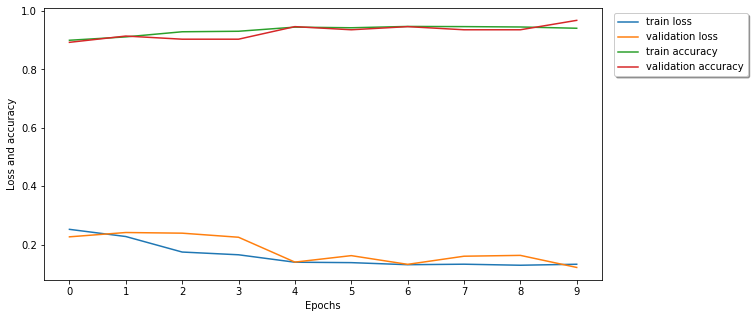

In [ ]:
plot_history(rnn_history)

In [ ]:
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=evaluate_metrics
)
rnn_scores = rnn_model.evaluate(test_dataset, return_dict=True)

1/1 [==============================] - 1s 542ms/step - loss: 0.1216 - binary_accuracy: 0.9677 - precision: 0.9342 - recall: 0.9467


# Comparing results

In [ ]:
def total_params(model):
    return tf.reduce_sum([tf.size(variables) for variables in model.variables]).numpy()

# Comparison of common parameters, training time and loss

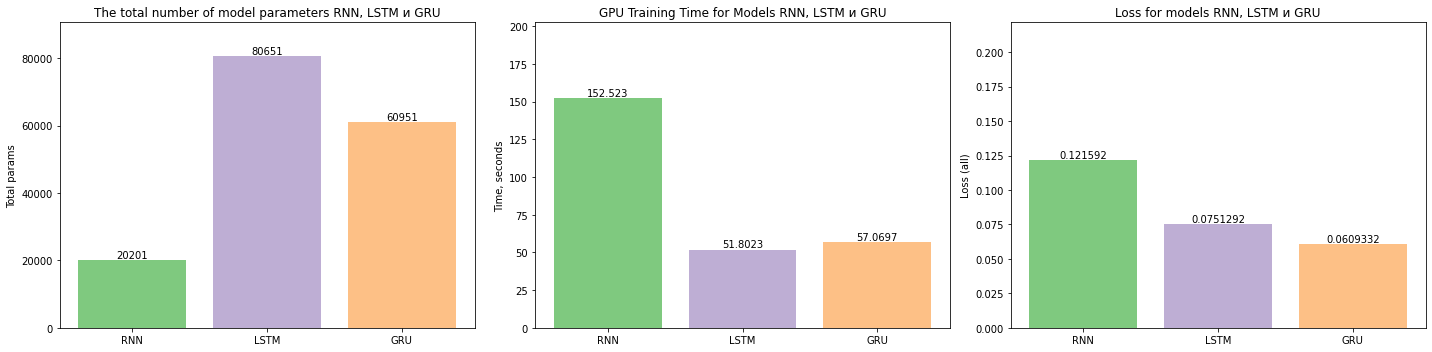

In [ ]:
labels = ['RNN', 'LSTM', 'GRU']
times = [rnn_train_time, lstm_train_time, gru_train_time]
params = [total_params(rnn_model), total_params(lstm_model), total_params(gru_model)]
losses = [rnn_scores['loss'], lstm_scores['loss'], gru_scores['loss']]

fig, ax = plt.subplots(1, 3)

fig.set_size_inches(20, 5)

x = [1, 2, 3]


colors = cm.Accent.colors[:len(x)]

bar = ax[0].bar(x, params, color=colors)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel('Total params')
ax[0].set_title('The total number of model parameters RNN, LSTM и GRU')
ax[0].bar_label(bar)
ax[0].set_ylim(0, np.max(params)+10000)


bar = ax[1].bar(x, times, color=colors)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_ylabel('Time, seconds')
ax[1].set_title('GPU Training Time for Models RNN, LSTM и GRU')
ax[1].bar_label(bar)
ax[1].set_ylim(0, np.max(times)+50)

bar = ax[2].bar(x, losses, color=colors)
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].set_ylabel('Loss (all)')
ax[2].set_title('Loss for models RNN, LSTM и GRU')
ax[2].bar_label(bar)
ax[2].set_ylim(0, np.max(losses)+0.1)

fig.tight_layout()

plt.show()

# Comparison of metrics for RNN, LSTM and GRU models

In [ ]:
rnn_scores

{'binary_accuracy': 0.9677419066429138,
 'loss': 0.12159227579832077,
 'precision': 0.9342105388641357,
 'recall': 0.9466666579246521}

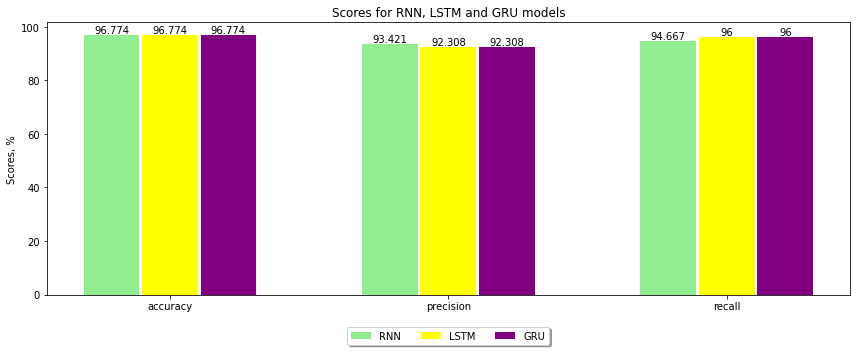

In [ ]:
labels = ['accuracy', 'precision', 'recall']
rnn_metrics = np.array([rnn_scores['binary_accuracy'], rnn_scores['precision'], rnn_scores['recall']]) * 100
lstm_metrics = np.array([lstm_scores['binary_accuracy'], lstm_scores['precision'], lstm_scores['recall']]) * 100
gru_metrics = np.array([gru_scores['binary_accuracy'], gru_scores['precision'], gru_scores['recall']]) * 100

a = "lightgreen" 
b = "yellow"
c = "purple"

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()

fig.set_size_inches(12, 5)

rnn_bar = ax.bar(x-width-0.01, np.round(rnn_metrics, 3), width, label='RNN', color=a)
lstm_bar = ax.bar(x, np.round(lstm_metrics, 3), width, label='LSTM', color=b)
gru_bar = ax.bar(x+width+0.01, np.round(gru_metrics, 3), width, label='GRU', color=c)

ax.set_ylabel('Scores, %')
ax.set_title('Scores for RNN, LSTM and GRU models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=True, shadow=True, ncol=3)

ax.bar_label(rnn_bar)
ax.bar_label(lstm_bar)
ax.bar_label(gru_bar)

fig.tight_layout()

plt.show()

# Comparison of CPU and GPU training times for RNN, LSTM and GRU models

In [ ]:
with tf.device('CPU:0'):
    _, lstm_train_time_cpu = train_model(lstm_model, verbose=0)
    print('LSTM on CPU is trained!')
with tf.device('GPU:0'):
    _, lstm_train_time_gpu = train_model(lstm_model, verbose=0)
    print('LSTM on GPU is trained!')

with tf.device('CPU:0'):
    _, gru_train_time_cpu = train_model(gru_model, verbose=0)
    print('GRU on CPU is trained!')
with tf.device('GPU:0'):
    _, gru_train_time_gpu = train_model(gru_model, verbose=0)
    print('GRU on GPU is trained!')

with tf.device('CPU:0'):
    _, rnn_train_time_cpu = train_model(rnn_model, verbose=0)
    print('RNN on CPU is trained!')
with tf.device('GPU:0'):
    _, rnn_train_time_gpu = train_model(rnn_model, verbose=0)
    print('RNN on GPU is trained!')

LSTM on CPU is trained!
LSTM on GPU is trained!
GRU on CPU is trained!
GRU on GPU is trained!
RNN on CPU is trained!
RNN on GPU is trained!


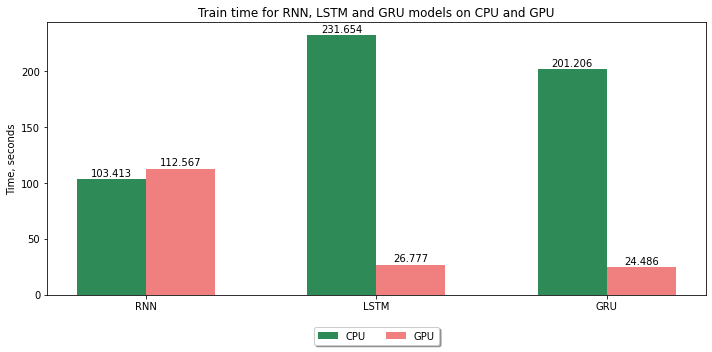

In [ ]:
labels = ['RNN', 'LSTM', 'GRU']
cpu_times = [rnn_train_time_cpu, lstm_train_time_cpu, gru_train_time_cpu]
gpu_times = [rnn_train_time_gpu, lstm_train_time_gpu, gru_train_time_gpu]

a = "seagreen"
b = "lightcoral"

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()

fig.set_size_inches(10, 5)

cpu_bar = ax.bar(x-width/2, np.round(cpu_times, 3), width, label='CPU', color=a)
gpu_bar = ax.bar(x+width/2, np.round(gpu_times, 3), width, label='GPU', color=b)

ax.set_ylabel('Time, seconds')
ax.set_title('Train time for RNN, LSTM and GRU models on CPU and GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=True, shadow=True, ncol=2)

ax.bar_label(cpu_bar, padding=1)
ax.bar_label(gpu_bar, padding=1)

fig.tight_layout()

plt.show()